In [1]:


import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


In [3]:
# Fetch historical data for Nifty50
nifty50 = yf.Ticker("^NSEI")
data = nifty50.history(period="5y")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-08-28 00:00:00+05:30,11101.299805,11129.650391,10987.650391,11046.099609,550000,0.0,0.0
2019-08-29 00:00:00+05:30,10996.049805,11021.099609,10922.400391,10948.299805,649900,0.0,0.0
2019-08-30 00:00:00+05:30,10987.799805,11042.599609,10874.799805,11023.250000,628200,0.0,0.0
2019-09-03 00:00:00+05:30,10960.950195,10967.500000,10772.700195,10797.900391,483000,0.0,0.0
2019-09-04 00:00:00+05:30,10790.400391,10858.750000,10746.349609,10844.650391,508800,0.0,0.0


<ipython-input-12-a71983d5785f>:7: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_year_data = data.last('1y')


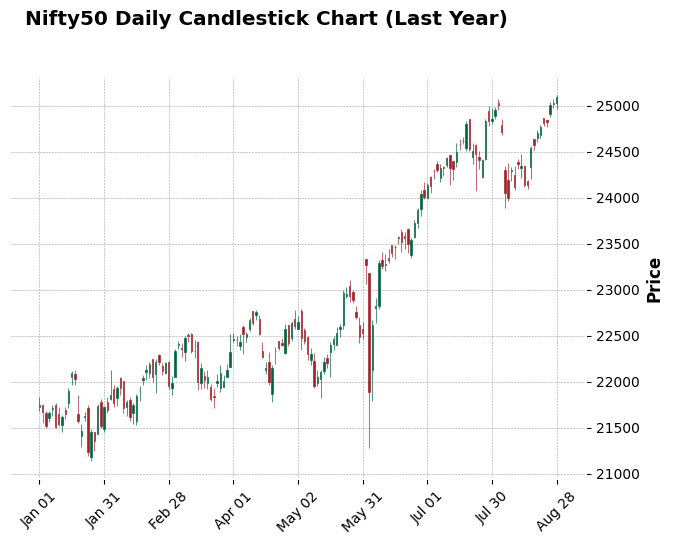

In [12]:
import matplotlib.pyplot as plt
import mplfinance as mpf  # Install using: !pip install mplfinance

# Assuming 'data' is your DataFrame with 'Date' as index and columns 'Open', 'High', 'Low', 'Close'

# Filter data for the last year (optional)
last_year_data = data.last('1y')

# Plot the candlestick chart
mpf.plot(last_year_data, type='candle', style='charles', title='Nifty50 Daily Candlestick Chart (Last Year)')

In [13]:
data['Price_Change'] = data['Close'].pct_change()
data['Target'] = np.where(data['Price_Change'] > 0, 1, 0)
data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Price_Change,Target
Date,,,,,,,,,
2019-08-29 00:00:00+05:30,10996.049805,11021.099609,10922.400391,10948.299805,649900,0.0,0.0,-0.008854,0
2019-08-30 00:00:00+05:30,10987.799805,11042.599609,10874.799805,11023.250000,628200,0.0,0.0,0.006846,1
2019-09-03 00:00:00+05:30,10960.950195,10967.500000,10772.700195,10797.900391,483000,0.0,0.0,-0.020443,0
2019-09-04 00:00:00+05:30,10790.400391,10858.750000,10746.349609,10844.650391,508800,0.0,0.0,0.004330,1
2019-09-05 00:00:00+05:30,10860.950195,10920.099609,10816.000000,10847.900391,595700,0.0,0.0,0.000300,1


In [14]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = data['Target']
# Scaling the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
# For simplicity, let's use the past 30 days of data to predict the next day
timesteps = 30
X_reshaped = []
y_reshaped = []

for i in range(timesteps, len(X_scaled)):
    X_reshaped.append(X_scaled[i-timesteps:i])
    y_reshaped.append(y.iloc[i])

X_reshaped, y_reshaped = np.array(X_reshaped), np.array(y_reshaped)
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)


In [19]:
# prompt: create a CNN model for the above dataset\

# Create the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5193 - loss: 0.7051 - val_accuracy: 0.6058 - val_loss: 0.6764
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5381 - loss: 0.6938 - val_accuracy: 0.6058 - val_loss: 0.6768
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5451 - loss: 0.6883 - val_accuracy: 0.6058 - val_loss: 0.6755
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5345 - loss: 0.6941 - val_accuracy: 0.6058 - val_loss: 0.6749
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5480 - loss: 0.6897 - val_accuracy: 0.6058 - val_loss: 0.6762
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5579 - loss: 0.6849 - val_accuracy: 0.6058 - val_loss: 0.6785
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5475 - loss: 0.6845 - val_accuracy: 0.6058 - val_loss: 0.6783
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5395 - loss: 0.6889 - val_accuracy: 0.6058 - val_l

In [27]:
#technical Indicators

data['SMA{}'.format(delta_days)] = ta.SMA(data['Close'], timeperiod=delta_days)
data['EMA{}'.format(delta_days)] = data['Close'].ewm(alpha=alpha, adjust=False).mean()
data['RSI'] = ta.RSI(data['Close'], timeperiod=14)
data['MACD'], _, _ = ta.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'], timeperiod=20)
data['ADX'] = ta.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)
data['CCI'] = ta.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)
data['ROC'] = ta.ROC(data['Close'], timeperiod=10)
data['StochasticK'], data['StochasticD'] = ta.STOCH(data['High'], data['Low'], data['Close'])
data['MOM'] = ta.MOM(data['Close'], timeperiod=10)  # Momentum
data['WILLR'] = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14) # Williams %R
data['OBV'] = ta.OBV(data['Close'], data['Volume'])  # On-Balance Volume
data['ADOSC'] = ta.ADOSC(data['High'], data['Low'], data['Close'], data['Volume'], fastperiod=3, slowperiod=10) # Chaikin A/D Oscillator
# Add more indicators as needed...

X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA30', 'EMA10', 'RSI', 'MACD', 'BB_upper', 'BB_middle', 'BB_lower', 'ADX', 'CCI', 'ROC', 'StochasticK', 'StochasticD', 'MOM', 'WILLR', 'OBV', 'ADOSC']]
y = data['Target']
# Scaling the features
#pca



  Using cached TA-Lib-0.4.32.tar.gz (368 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for TA-Lib
Failed to build TA-Lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (TA-Lib)


ModuleNotFoundError: No module named 'ta'

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=5 with svd_solver='full'